In [61]:
!pip install Xgboost

In [75]:
import pandas as pd
import numpy as np
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt


In [76]:
# Load Dataset
df = pd.read_csv("oil_retail_history.csv")
df.head() # show first five rows


,date,price,cost,comp1_price,comp2_price,comp3_price,volume
0,2023-01-01,97.66,86.46,98.39,99.10,97.37,13513
1,2023-01-02,96.46,87.25,95.37,96.25,97.38,13605
2,2023-01-03,94.67,86.40,94.41,94.69,94.50,16540
3,2023-01-04,97.32,87.51,99.12,96.90,97.54,14927
4,2023-01-05,94.08,86.38,93.31,94.61,93.85,13332


In [77]:
# Check missing values:
df.isna().sum()


,0
date,0
price,0
cost,0
comp1_price,0
comp2_price,0
comp3_price,0
volume,0


In [78]:

# ADVANCED DATA VALIDATION & CLEANING

# Remove negative or zero entries
df = df[df['price'] > 0]
df = df[df['cost'] > 0]
df = df[df['volume'] > 0]

# Cost should generally be <= price (no loss pricing historically)
df = df[df['price'] >= df['cost']]

# Remove unrealistic outliers using IQR rule
Q1 = df['volume'].quantile(0.25)
Q3 = df['volume'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df['volume'] >= lower) & (df['volume'] <= upper)]

print("Data after validation:", df.shape)


Data after validation: (722, 7)


In [79]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])
## Sort by date to respect time order
df = df.sort_values('date')


In [80]:
df.describe()

,date,price,cost,comp1_price,comp2_price,comp3_price,volume
count,722,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000
mean,2024-01-01 14:43:32.742382336,96.523989,86.498740,96.564252,96.543089,96.469321,13938.753463
min,2023-01-01 00:00:00,88.080000,83.340000,88.320000,87.070000,86.080000,11894.000000
25%,2023-07-04 06:00:00,94.692500,85.302500,94.580000,94.855000,94.730000,13319.250000
50%,2024-01-01 12:00:00,96.530000,86.255000,96.595000,96.450000,96.535000,13878.500000
75%,2024-07-01 18:00:00,98.430000,87.610000,98.480000,98.450000,98.107500,14530.500000
max,2024-12-30 00:00:00,104.890000,91.860000,104.200000,105.000000,104.360000,16342.000000
std,NaN,2.744703,1.578911,2.785762,2.806835,2.782733,866.757391


In [81]:
print(df.shape)
df.head()

(722, 7)


,date,price,cost,comp1_price,comp2_price,comp3_price,volume
0,2023-01-01,97.66,86.46,98.39,99.10,97.37,13513
1,2023-01-02,96.46,87.25,95.37,96.25,97.38,13605
3,2023-01-04,97.32,87.51,99.12,96.90,97.54,14927
4,2023-01-05,94.08,86.38,93.31,94.61,93.85,13332
5,2023-01-06,96.73,88.24,97.27,97.17,97.23,13643


In [82]:
# Create profit & exploratory plots (EDA)
df["profit"] = (df["price"] - df["cost"]) * df["volume"]



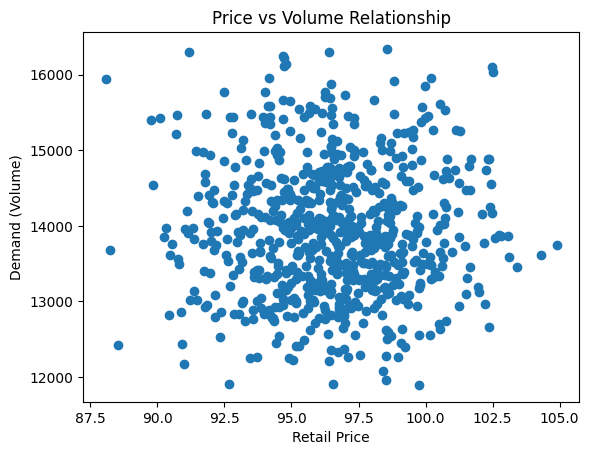

In [83]:
# # Price vs Volume scatter plot
plt.scatter(df["price"], df["volume"])
plt.xlabel("Retail Price")
plt.ylabel("Demand (Volume)")
plt.title("Price vs Volume Relationship")
plt.show()

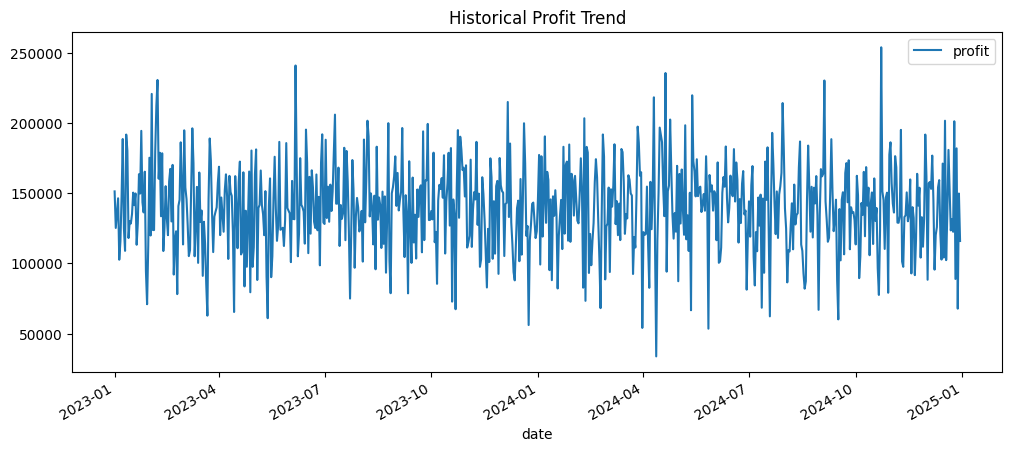

In [84]:
# Profit over time
df.plot(figsize=(12, 5), x="date", y="profit", title="Historical Profit Trend")
plt.show()

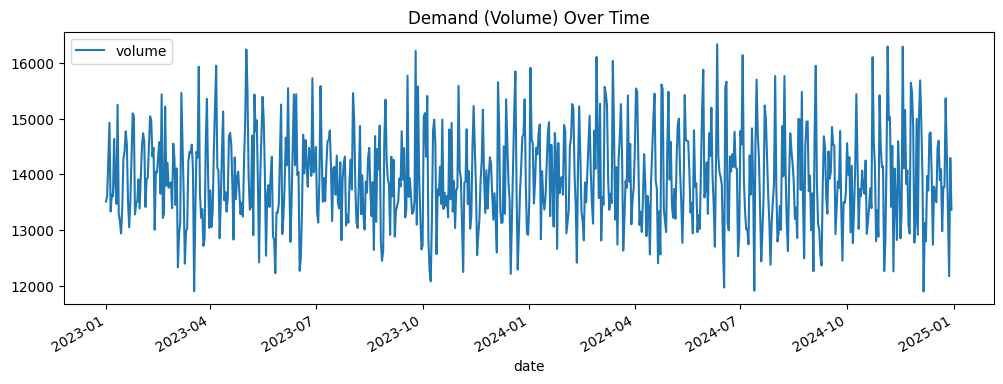

In [87]:

# DEMAND DYNAMICS & SEASONALITY ANALYSIS

#  Volume time-series trend
df.plot(figsize=(12,4), x='date', y='volume', title='Demand (Volume) Over Time')
plt.show()




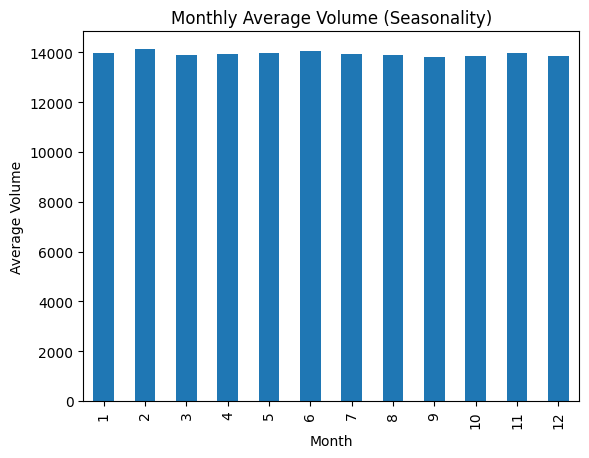

In [88]:
#  Monthly seasonality pattern
df['month'] = df['date'].dt.month
df.groupby('month')['volume'].mean().plot(kind='bar')
plt.title("Monthly Average Volume (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Average Volume")
plt.show()



In [90]:
# Feature engineering

# Margin per liter
df["margin"] = df["price"] - df["cost"]

# Average competitor price
df["avg_comp_price"] = df[["comp1_price","comp2_price","comp3_price"]].mean(axis=1)

# Price difference vs competitors
df["price_comp_diff"] = df["price"] - df["avg_comp_price"]

# Lag features for demand memory effect
df["lag_volume"] = df["volume"].shift(1)
df["lag_price"] = df["price"].shift(1)

# Moving average volume (weekly trend)
df["ma7_volume"] = df["volume"].rolling(7).mean()

# Drop NA introduced by shifts
df = df.dropna()


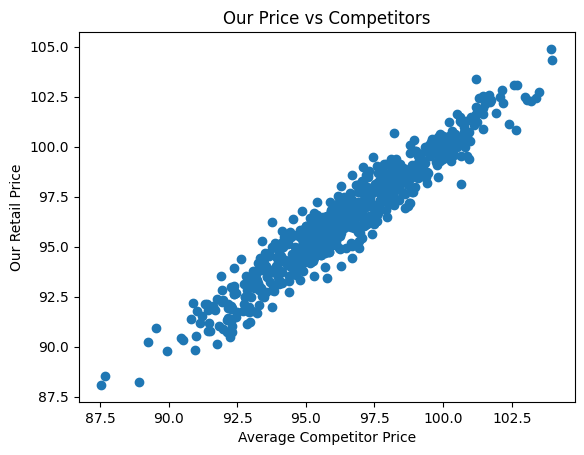

In [91]:
#  Competitor price vs our price
plt.scatter(df['avg_comp_price'], df['price'])
plt.xlabel("Average Competitor Price")
plt.ylabel("Our Retail Price")
plt.title("Our Price vs Competitors")
plt.show()

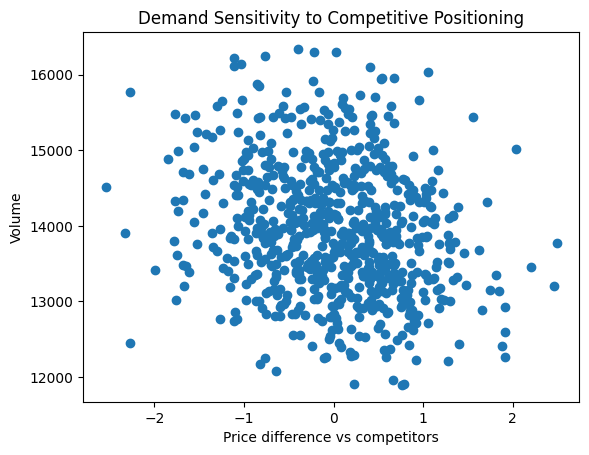

In [92]:
# Volume vs competitor price difference
plt.scatter(df['price_comp_diff'], df['volume'])
plt.xlabel("Price difference vs competitors")
plt.ylabel("Volume")
plt.title("Demand Sensitivity to Competitive Positioning")
plt.show()

In [93]:

# DATA PIPELINE DESIGN (INGEST → TRANSFORM → STORE)


# Simulate daily batch ingestion
def ingest_daily_batch(new_data: pd.DataFrame, master: pd.DataFrame):
    """
    Simulates daily batch ingestion of retail fuel data.
    """
    combined = pd.concat([master, new_data], ignore_index=True)
    combined = combined.drop_duplicates()
    combined = combined.sort_values("date")
    return combined


# Transformation / feature computation pipeline
def transform_features(data: pd.DataFrame):

    data = data.copy()

    data['margin'] = data['price'] - data['cost']
    data['avg_comp_price'] = data[['comp1_price','comp2_price','comp3_price']].mean(axis=1)
    data['price_comp_diff'] = data['price'] - data['avg_comp_price']
    data['lag_volume'] = data['volume'].shift(1)
    data['lag_price'] = data['price'].shift(1)
    data['ma7_volume'] = data['volume'].rolling(7).mean()

    data = data.dropna()
    return data


# store final dataset ready for ML
processed_df = transform_features(df)

processed_df.to_csv("processed_training_data.csv", index=False)

print("Processed dataset saved as processed_training_data.csv")
processed_df.head()


Processed dataset saved as processed_training_data.csv


,date,price,cost,comp1_price,comp2_price,comp3_price,volume,profit,month,margin,avg_comp_price,price_comp_diff,lag_volume,lag_price,ma7_volume
13,2023-01-14,97.48,87.42,97.87,96.26,97.52,12938,130156.28,1,10.06,97.216667,0.263333,13154.0,95.88,13801.571429
14,2023-01-15,97.04,87.44,96.18,98.43,97.78,13381,128457.60,1,9.60,97.463333,-0.423333,12938.0,97.48,13622.000000
15,2023-01-16,96.87,87.40,94.87,96.70,97.02,14275,135184.25,1,9.47,96.196667,0.673333,13381.0,97.04,13680.285714
16,2023-01-17,96.84,86.40,98.17,99.17,96.44,14412,150461.28,1,10.44,97.926667,-1.086667,14275.0,96.87,13814.714286
17,2023-01-18,96.39,86.81,98.05,95.97,97.30,14773,141525.34,1,9.58,97.106667,-0.716667,14412.0,96.84,13746.571429


In [94]:
# Define features and target variable

# Target variable = demand (volume)
target = "volume"

# Model input features
features = [
    "price",
    "cost",
    "avg_comp_price",
    "price_comp_diff",
    "margin",
    "lag_volume",
    "lag_price",
    "ma7_volume"
]

X = df[features]
y = df[target]

In [95]:
# Train–test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [96]:
# Train Random Forest model
model = RandomForestRegressor(n_estimators=300,random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=300, random_state=42)

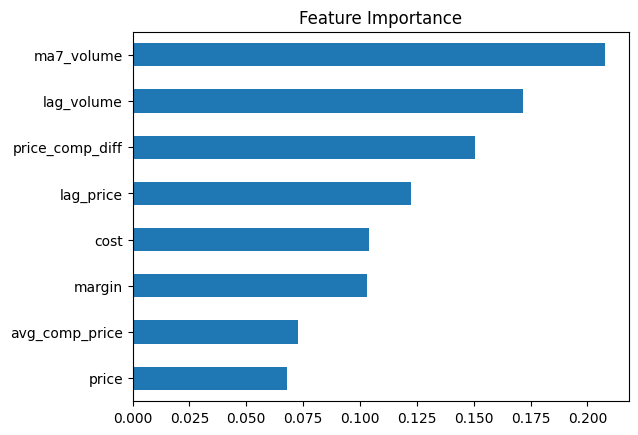

In [97]:

# FEATURE IMPORTANCE ANALYSIS

importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values()

importances.plot(kind="barh", title="Feature Importance")
plt.show()


In [98]:
# Model evaluation

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics")
print("-------------------------")
print("RMSE:", rmse)
print("R2 Score:", r2)


Model Evaluation Metrics
-------------------------
RMSE: 883.0500423462163
R2 Score: 0.04428543142114727


In [99]:

# STRATEGY VALIDATION – BACKTESTING


def simulate_profit(row):
    margin = row['price'] - row['cost']
    return margin * row['volume']

# historical profit earned
historical_profit = df.apply(simulate_profit, axis=1).sum()

print("Historical realized profit:", historical_profit)


Historical realized profit: 100035852.68


In [100]:
# Define price optimization function

# Function to recommend daily price maximizing profit
def recommend_price(today_data, model):

    price_yesterday = df.iloc[-1]["price"]
    cost_today = today_data["cost"]

    # Candidate price search grid
    candidate_prices = np.arange(price_yesterday - 3,
                                 price_yesterday + 3,
                                 0.1)

    best_price = None
    best_volume = None
    best_profit = -1

    for p in candidate_prices:

        avg_comp = np.mean([
            today_data["comp1_price"],
            today_data["comp2_price"],
            today_data["comp3_price"]
        ])

        # -----------------------
        # Business Constraints
        # -----------------------

        # 1) minimum margin: no selling at loss
        if p < cost_today:
            continue

        # 2) price cannot move more than ±2 INR in a day
        if abs(p - price_yesterday) > 2:
            continue

        # 3) stay within ₹2 of average competitor price
        if p > avg_comp + 2:
            continue

        # Build feature vector for model
        row = pd.DataFrame([{
            "price": p,
            "cost": cost_today,
            "avg_comp_price": avg_comp,
            "price_comp_diff": p - avg_comp,
            "margin": p - cost_today,
            "lag_volume": df.iloc[-1]["volume"],
            "lag_price": price_yesterday,
            "ma7_volume": df["volume"].tail(7).mean()
        }])

        volume_pred = model.predict(row)[0]

        profit = (p - cost_today) * volume_pred

        if profit > best_profit:
            best_profit = profit
            best_price = p
            best_volume = volume_pred

    return best_price, best_volume, best_profit


In [101]:
# Load today_example.json

with open("/content/today_example.json") as f:
    today_data = json.load(f)

today_data


{'date': '2024-12-31',
 'price': 94.45,
 'cost': 85.77,
 'comp1_price': 95.01,
 'comp2_price': 95.7,
 'comp3_price': 95.21}

In [102]:
# Generate final recommendation

price, volume, profit = recommend_price(today_data, model)

print("Recommended retail price:", round(price, 2))
print("Expected demand volume:", int(volume))
print("Expected profit:", round(profit, 2))

Recommended retail price: 96.45
Expected demand volume: 13450
Expected profit: 143651.98
